# Quantify organelle morphology - part 1.1
--------------------

## OVERVIEW
Now that all organelles and masks are segmented, we can begin to quantify features of organelle composition, morphology, interactions, and distribution. 


## OBJECTIVE: ✅ Quantify ***organelle*** composition and morphology
In this notebook, the logic for quantifying organelle composition (how much of each organelle is present) and morphology (individual size and shape) is outlined.



## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
import itertools

import parse

import napari

from skimage.measure import (regionprops, _regionprops, regionprops_table)

from napari.utils.notebook_display import nbscreenshot

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc.core.file_io import (read_czi_image,
                                        export_inferred_organelle,
                                        import_inferred_organelle,
                                        export_tiff,
                                        list_image_files)

from infer_subc.core.img import *
from infer_subc.utils.stats import *
from infer_subc.utils.stats import (_my_props_to_dict, _assert_uint16_labels)
from infer_subc.utils.stats_helpers import *

from infer_subc.organelles import * 

from infer_subc.constants import (TEST_IMG_N,
                                    NUC_CH ,
                                    LYSO_CH ,
                                    MITO_CH ,
                                    GOLGI_CH ,
                                    PEROX_CH ,
                                    ER_CH ,
                                    LD_CH ,
                                    RESIDUAL_CH ) 

import time
%load_ext autoreload
%autoreload 2

## Get and load image for quantification
Specifically, this will include the raw image and the outputs from segmentation.

In [2]:
test_img_n = TEST_IMG_N

data_root_path = Path(os.path.expanduser("~")) / "Documents/Python_Scripts/Infer-subc"

raw_data_path = data_root_path / "raw"
im_type = ".czi"

raw_file_list = list_image_files(raw_data_path,im_type)
raw_img_name = raw_file_list[test_img_n]

# adding an additional list of image paths for the matching segmentation files
seg_data_path = data_root_path / "out"
seg_file_list = list_image_files(seg_data_path, "tiff")

# changing output directory for this notebook to a new folder called "quant"
out_data_path = data_root_path / "quant"
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [3]:
# raw image
raw_img_data, raw_meta_dict = read_czi_image(raw_img_name)

channel_names = raw_meta_dict['name']
img = raw_meta_dict['metadata']['aicsimage']
scale = raw_meta_dict['scale']
channel_axis = raw_meta_dict['channel_axis']

In [4]:
## For each import, change the string to match the suffix on the segmentation files (i.e., the stuff following the "-")

# masks
nuc_seg = import_inferred_organelle("20230426_test_nuc", raw_meta_dict, seg_data_path)
cell_seg = import_inferred_organelle("20230426_test_cell", raw_meta_dict, seg_data_path)
cyto_seg = import_inferred_organelle("20230426_test_cyto", raw_meta_dict, seg_data_path)
# mask_seg = import_inferred_organelle("masks", raw_meta_dict, seg_data_path)

#organelles
lyso_seg = import_inferred_organelle("20230426_test_lyso", raw_meta_dict, seg_data_path)
mito_seg = import_inferred_organelle("20230426_test_mito", raw_meta_dict, seg_data_path)
golgi_seg = import_inferred_organelle("20230426_test_golgi", raw_meta_dict, seg_data_path)
perox_seg = import_inferred_organelle("20230426_test_perox", raw_meta_dict, seg_data_path)
ER_seg = import_inferred_organelle("20230426_test_ER", raw_meta_dict, seg_data_path)
LD_seg = import_inferred_organelle("20230426_test_LD", raw_meta_dict, seg_data_path)


loaded  inferred 3D `20230426_test_nuc`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_cell`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_cyto`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_lyso`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_mito`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_golgi`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_perox`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_ER`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_LD`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 


-------------------------
## Visualize the image and segmentation outputs

In [5]:
viewer = napari.Viewer()

25-Oct-23 12:38:01 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1086x657+640+242 (frame: 1104x704+631+204) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 905x825+638+235 (frame: 923x872+629+197) margins: 9, 38, 9, 9 minimum size: 385x515 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=403,562 maxtrack=0,0)


In [6]:
viewer.add_image(raw_img_data)

<Image layer 'raw_img_data' at 0x2dc75801f60>

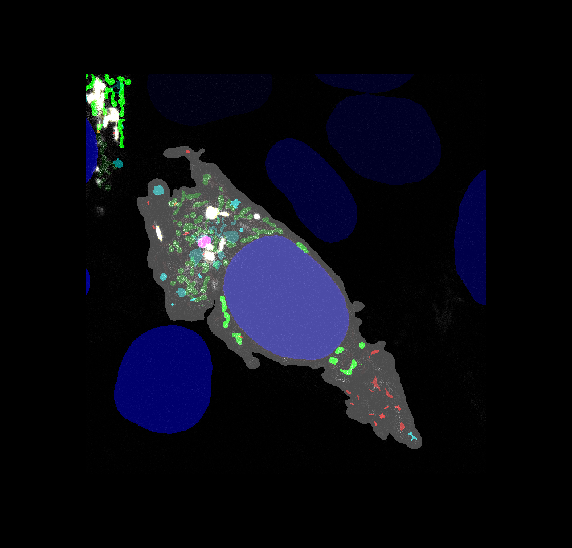

In [7]:
viewer.add_image(cell_seg, colormap='gray', opacity=0.3, blending ='additive')

viewer.add_image(nuc_seg, colormap='blue', blending ='additive')
viewer.add_image(lyso_seg, colormap='cyan', blending ='additive')
viewer.add_image(mito_seg, colormap='green', blending ='additive')
viewer.add_image(golgi_seg, colormap='yellow', blending ='additive')
viewer.add_image(perox_seg, colormap='bop orange', blending ='additive')
viewer.add_image(ER_seg, colormap='red', blending ='additive')
viewer.add_image(LD_seg, colormap='magenta', blending ='additive')

nbscreenshot(viewer, canvas_only=True)

In [8]:
viewer.close()

-------------------------
## Exploring the regionprops measurements

### Some regionprops measurements are not possible in 3D or with real world units:

> Below, we have listed the properties that are supported in 3D and the properties that support scaling to real-world units.
>
> NOTE: 
> The regionprop property names correspond to 2D measurements even for those that are able to function in 3D (i.e. "area" is actually "volume" when a 3D image is being processed, etc.).

In [9]:
labels = label(nuc_seg )
rp = regionprops(labels, intensity_image=raw_img_data[NUC_CH], spacing=scale)

supported = [] 
unsupported = []

for prop in rp[0]:
    try:
        rp[0][prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print("Supported properties for 3D analysis:")
print("  " + "\n  ".join(supported))
print()
print("Properties only supported in 2D:")
print("  " + "\n  ".join(unsupported))

Supported properties for 3D analysis:
  area
  area_bbox
  area_convex
  area_filled
  axis_major_length
  axis_minor_length
  bbox
  centroid
  centroid_local
  centroid_weighted
  centroid_weighted_local
  coords
  equivalent_diameter_area
  euler_number
  extent
  feret_diameter_max
  image
  image_convex
  image_filled
  image_intensity
  inertia_tensor
  inertia_tensor_eigvals
  intensity_max
  intensity_mean
  intensity_min
  label
  moments
  moments_central
  moments_normalized
  moments_weighted
  moments_weighted_central
  moments_weighted_normalized
  slice
  solidity

Properties only supported in 2D:
  eccentricity
  moments_hu
  moments_weighted_hu
  orientation
  perimeter
  perimeter_crofton


Below, we have listed the observed properties and the affect of scaling via real-world units (microns):

Scaled
>- volume: n * zyx
>- equivalent diameter: n * zyx**(1/3)
>- centroid-0: n * z
>- centroid-1: n * y
>- centroid-2: n * x
>- surface_area: varies by shape and orientation

Not Scaled
>- bbox (0-5)
>- euler_number
>- extent
>- max_intensity
>- mean_intensity
>- min_intensity
>- standard_deviation_intensity

---------
## **Organelle Morphology**

### summary of steps

🛠️ BUILD FUNCTION PROTOTYPE

- **`0`** - Apply Cell Mask *(preliminary step)*

- **`1`** - Build the list of measurements we want to include from regionprops 

- **`2`** - Add additional measurements as *"extra_properties"* with custom functions.

- **`3`** - Run regionprops and export values as a pandas dataframe

- **`4`** - Add additional measurements
    - surface area
    - surface area to volume ratio

⚙️ EXECUTE FUNCTION PROTOTYPE

- Define `_get_org_morphology_3D` function
- Run `_get_org_morphology_3D` function
    - scaled and unscaled
- Compare to finalized `get_org_morphology_3D` function

-------------------------
# **regionprops**

To measure the amount, size, and shape of the individual organelles, we will utilize `skimage.measure.regionprops`. These measurements can be collected based on pixel/voxel units (assuming the image is isotropic in all dimensions) and or "real-world" units. Since most confocal microscope images are anisotropic (mostly with respect to the Z dimension), we will preferentially utilize real-world units. Luckily, regionprops>=0.20.0 has incorporated a spacing parameter that can handle anisotropic data.

Similar concepts will also be applied to measure the cell, cytoplasm, and nucleus below as well in notebook 1.4.

# ***BUILD FUNCTION PROTOTYPE***

## **`0` - Apply Cell Mask**
To ensure we are performing single cell analysis, we will apply the cell segmentation as a mask.

> ###### The Golgi body segmentation will be the example used throughout this notebook

In [10]:
golgi_masked = apply_mask(golgi_seg, cell_seg)

## **`1` - Build the list of measurements we want to include from regionprops**

In [11]:
# start with LABEL
test_properties = ["label"]

# add position
test_properties = test_properties + ["centroid", "bbox"]

# add area
test_properties = test_properties + ["area", "equivalent_diameter"] # "num_pixels", 

# add shape measurements
test_properties = test_properties + ["extent", "euler_number", "solidity", "axis_major_length"] # "feret_diameter_max", "axis_minor_length"]

# add intensity values (used for quality checks only)
test_properties = test_properties + ["min_intensity", "max_intensity", "mean_intensity"]

test_properties

['label',
 'centroid',
 'bbox',
 'area',
 'equivalent_diameter',
 'extent',
 'euler_number',
 'solidity',
 'axis_major_length',
 'min_intensity',
 'max_intensity',
 'mean_intensity']

## **`2` - Add additional measurements as *"extra_properties"* with custom functions**

In [12]:
# create a function to include the standard deviation of intensities (for quality checks only)
def _standard_deviation_intensity(region, intensities):
    return np.std(intensities[region])

test_extra_properties = [_standard_deviation_intensity]

In [ ]:
### Potential Update
# creating a function to slightly alter the existing minor_axis_length measurement

## **`3` - Run regionprops and export values as a pandas dataframe**

In [42]:
test_props = regionprops_table(golgi_masked,
                            intensity_image=raw_img_data[0], 
                            properties=test_properties,
                            extra_properties=test_extra_properties,
                            spacing=scale)

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 516114181  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 14  Error-roundoff 1.9e-14  _one-merge 1.4e-13
  _near-inside 6.8e-13  Visible-distance 3.9e-14  U-max-coplanar 3.9e-14
  Width-outside 7.8e-14  _wide-facet 2.3e-13  _maxoutside 1.6e-13

  return convex_hull_image(self.image)
c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:630: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex


In [43]:
test_props_unscaled = regionprops_table(golgi_masked,
                            intensity_image=raw_img_data[0], 
                            properties=test_properties,
                            extra_properties=test_extra_properties)

In [44]:
test_props_table = pd.DataFrame(test_props)

test_org_name = "golgi"
test_props_table.insert(1, "object", test_org_name)
test_props_table.rename(columns={"area": "volume"}, inplace=True)

round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
test_props_table.insert(loc=2, column="scale", value=f"{round_scale}")

## **`4` - Add additional measurements**

- surface area
- surface area to volume ratio

In [45]:
# creating a function to measure the surface area of each object. This function utilizes "marching_cubes" to generate a mesh (non-pixelated object)
def _surface_area_from_props(labels: np.ndarray,
                             props: dict,
                             scale: Union[tuple, None]=None):
    """ 
    a function for getting surface area of volumetric objects

    Parameters:
    ----------
    lables:
        the segmentation np.ndarray with each object labeled a different number
    props:
        region props dictionary resulting from the _my_props_to_dict() function
    spacing:
        tuple of the dimension lengths in the same order as the dimension of your np.ndarray labels input
    """
    surface_areas = np.zeros(len(props["label"]))

    for index, lab in enumerate(props["label"]):
        # this seems less elegant than you might wish, given that regionprops returns a slice,
        # but we need to expand the slice out by one voxel in each direction, or surface area freaks out
        volume = labels[
            max(props["bbox-0"][index] - 1, 0) : min(props["bbox-3"][index] + 1, labels.shape[0]),
            max(props["bbox-1"][index] - 1, 0) : min(props["bbox-4"][index] + 1, labels.shape[1]),
            max(props["bbox-2"][index] - 1, 0) : min(props["bbox-5"][index] + 1, labels.shape[2]),
        ]
        volume = volume == lab
        if scale is None:
            scale=(1.0,) * labels.ndim
        verts, faces, _normals, _values = marching_cubes(volume,
                                                         method="lewiner",
                                                         spacing=scale,
                                                         level=0)
        
        surface_areas[index] = mesh_surface_area(verts, faces)

    return surface_areas

In [46]:
# props["surface_area"] = surface_area_from_props(nuc_seg, props)
test_surface_area_tab = pd.DataFrame(_surface_area_from_props(golgi_masked, test_props, scale))

test_props_table.insert(12, "surface_area", test_surface_area_tab)
test_props_table.insert(14, "SA_to_volume_ratio", test_props_table["surface_area"].div(test_props_table["volume"]))

pd.set_option('display.max_columns', None)
test_props_table

,label,object,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,surface_area,volume,SA_to_volume_ratio,equivalent_diameter,extent,euler_number,solidity,axis_major_length,min_intensity,max_intensity,mean_intensity,_standard_deviation_intensity
0,1,golgi,"(0.3891, 0.0799, 0.0799)",2.961140,25.181697,18.171747,0,276,182,15,370,279,135.579215,26.514236,5.113450,3.699646,0.078095,1,0.248136,9.164190,0.0,3147.0,76.989701,221.975259
1,3,golgi,"(0.3891, 0.0799, 0.0799)",1.362499,25.808138,14.335402,3,308,172,5,342,190,9.399228,0.826631,11.370531,1.164406,0.272059,1,0.789100,2.934292,0.0,2641.0,68.015015,213.683475
2,4,golgi,"(0.3891, 0.0799, 0.0799)",1.167355,26.161862,19.042084,3,321,231,4,335,246,4.895599,0.407109,12.025270,0.919540,0.780952,1,inf,1.358344,0.0,1620.0,50.743902,205.234002
3,5,golgi,"(0.3891, 0.0799, 0.0799)",3.567122,19.622267,18.042716,4,223,208,15,270,254,53.883197,11.952630,4.508062,2.836754,0.202464,1,0.496801,5.283393,0.0,2606.0,51.269574,167.103095
4,6,golgi,"(0.3891, 0.0799, 0.0799)",1.956617,22.657591,16.101593,4,268,191,7,298,214,13.351535,1.489424,8.964225,1.416902,0.289855,0,0.723764,2.815886,0.0,1209.0,16.451667,80.660178
5,7,golgi,"(0.3891, 0.0799, 0.0799)",1.948433,29.835657,18.349492,4,364,224,7,385,237,8.612446,1.020256,8.441459,1.249022,0.501832,1,0.805882,1.847332,0.0,1961.0,69.596107,201.045594
6,9,golgi,"(0.3891, 0.0799, 0.0799)",3.485415,22.369099,10.471821,8,265,124,11,294,140,10.974168,1.102174,9.956838,1.281594,0.318966,1,0.716129,2.440131,0.0,1084.0,56.472973,151.539567
7,10,golgi,"(0.3891, 0.0799, 0.0799)",4.363178,21.707823,22.104662,9,253,243,14,285,310,37.351765,5.431434,6.876962,2.180914,0.204104,1,0.403616,6.706301,0.0,1925.0,67.994973,184.555059
8,12,golgi,"(0.3891, 0.0799, 0.0799)",4.080419,27.772298,14.146867,10,336,170,12,361,186,9.107892,1.179128,7.724263,1.310753,0.593750,1,0.889513,1.956575,0.0,1004.0,43.774737,131.754324
9,13,golgi,"(0.3891, 0.0799, 0.0799)",4.490122,21.838828,15.402700,11,261,179,13,284,207,10.176071,1.012809,10.047379,1.245976,0.316770,1,0.766917,3.167001,0.0,1818.0,50.629902,171.807170


# ***EXECUTE FUNCTION PROTOTYPE***

## **Define `get_org_morphology_3D()` function**

Based on the _prototyping_ above define the function to quantify amount, size, and shape of organelles.

In [27]:
def _get_org_morphology_3D(segmentation_img: np.ndarray, 
                           seg_name: str, 
                           intensity_img, 
                           mask: np.ndarray, 
                           scale: Union[tuple, None]=None):
    """
    Parameters
    ------------
    segmentation_img:
        a 3D (ZYX) np.ndarray of segmented objects 
    seg_name: str
        a name or nickname of the object being measured; this will be used for record keeping in the output table
    intensity_img:
        a 3D (ZYX) np.ndarray contain gray scale values from the "raw" image the segmentation is based on )single channel)
    mask:
        a 3D (ZYX) binary np.ndarray mask of the area to measure from
    scale: tuple, optional
        a tuple that contains the real world dimensions for each dimension in the image (Z, Y, X)


    Regionprops measurements:
    ------------------------
    ['label',
    'centroid',
    'bbox',
    'area',
    'equivalent_diameter',
    'extent',
    'feret_diameter_max',
    'euler_number',
    'convex_area',
    'solidity',
    'axis_major_length',
    'axis_minor_length',
    'max_intensity',
    'mean_intensity',
    'min_intensity']

    Additional measurements:
    -----------------------
    ['standard_deviation_intensity',
    'surface_area']


    Returns
    -------------
    pandas dataframe of containing regionprops measurements (columns) for each object in the segmentation image (rows) and the regionprops object
    
    """
    ###################################################
    ## MASK THE ORGANELLE OBJECTS THAT WILL BE MEASURED
    ###################################################
    # in case we sent a boolean mask (e.g. cyto, nucleus, cellmask)
    input_labels = _assert_uint16_labels(segmentation_img)

    # mask
    input_labels = apply_mask(input_labels, mask)

    ##########################################
    ## CREATE LIST OF REGIONPROPS MEASUREMENTS
    ##########################################
    # start with LABEL
    properties = ["label"]

    # add position
    properties = properties + ["centroid", "bbox"]

    # add area
    properties = properties + ["area", "equivalent_diameter"] # "num_pixels", 

    # add shape measurements
    properties = properties + ["extent", "euler_number", "solidity", "axis_major_length"] # ,"feret_diameter_max", "axis_minor_length"]

    # add intensity values (used for quality checks)
    properties = properties + ["min_intensity", "max_intensity", "mean_intensity"]

    #######################
    ## ADD EXTRA PROPERTIES
    #######################
    def standard_deviation_intensity(region, intensities):
        return np.std(intensities[region])

    extra_properties = [standard_deviation_intensity]

    ##################
    ## RUN REGIONPROPS
    ##################
    props = regionprops_table(input_labels, 
                           intensity_image=intensity_img, 
                           properties=properties,
                           extra_properties=extra_properties,
                           spacing=scale)

    props_table = pd.DataFrame(props)
    props_table.insert(0, "object", seg_name)
    props_table.rename(columns={"area": "volume"}, inplace=True)

    if scale is not None:
        round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
        props_table.insert(loc=2, column="scale", value=f"{round_scale}")
    else: 
        props_table.insert(loc=2, column="scale", value=f"{tuple(np.ones(segmentation_img.ndim))}") 

    ##################################################################
    ## RUN SURFACE AREA FUNCTION SEPARATELY AND APPEND THE PROPS_TABLE
    ##################################################################
    surface_area_tab = pd.DataFrame(_surface_area_from_props(input_labels, props, scale))

    props_table.insert(12, "surface_area", surface_area_tab)
    props_table.insert(14, "SA_to_volume_ratio", props_table["surface_area"].div(props_table["volume"]))

    ################################################################
    ## ADD SKELETONIZATION OPTION FOR MEASURING LENGTH AND BRANCHING
    ################################################################
    #  # ETC.  skeletonize via cellprofiler /Users/ahenrie/Projects/Imaging/CellProfiler/cellprofiler/modules/morphologicalskeleton.py
    #         if x.volumetric:
    #             y_data = skimage.morphology.skeletonize_3d(x_data)
    # /Users/ahenrie/Projects/Imaging/CellProfiler/cellprofiler/modules/measureobjectskeleton.py

    return props_table

## **Run `_get_org_morphology_3D` function**

In [28]:
org_img = raw_img_data[0]
seg_name = 'golgi'
org_obj = golgi_seg
cell_mask = cell_seg

# with scale
golgi_table = _get_org_morphology_3D(segmentation_img=org_obj, seg_name=seg_name, intensity_img=org_img, mask=cell_mask, scale=scale)
# without scale
golgi_table_unscaled = _get_org_morphology_3D(segmentation_img=org_obj, seg_name=seg_name, intensity_img=org_img, mask=cell_mask, scale=None)

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 513004886  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 14  Error-roundoff 1.9e-14  _one-merge 1.4e-13
  _near-inside 6.8e-13  Visible-distance 3.9e-14  U-max-coplanar 3.9e-14
  Width-outside 7.8e-14  _wide-facet 2.3e-13  _maxoutside 1.6e-13

  return convex_hull_image(self.image)
c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:630: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Fai

> Table with scaled metrics

In [29]:
golgi_table

,object,label,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,surface_area,volume,SA_to_volume_ratio,equivalent_diameter,extent,euler_number,solidity,axis_major_length,min_intensity,max_intensity,mean_intensity,standard_deviation_intensity
0,golgi,1,"(0.3891, 0.0799, 0.0799)",2.961140,25.181697,18.171747,0,276,182,15,370,279,135.579215,26.514236,5.113450,3.699646,0.078095,1,0.248136,9.164190,0.0,3147.0,76.989701,221.975259
1,golgi,3,"(0.3891, 0.0799, 0.0799)",1.362499,25.808138,14.335402,3,308,172,5,342,190,9.399228,0.826631,11.370531,1.164406,0.272059,1,0.789100,2.934292,0.0,2641.0,68.015015,213.683475
2,golgi,4,"(0.3891, 0.0799, 0.0799)",1.167355,26.161862,19.042084,3,321,231,4,335,246,4.895599,0.407109,12.025270,0.919540,0.780952,1,inf,1.358344,0.0,1620.0,50.743902,205.234002
3,golgi,5,"(0.3891, 0.0799, 0.0799)",3.567122,19.622267,18.042716,4,223,208,15,270,254,53.883197,11.952630,4.508062,2.836754,0.202464,1,0.496801,5.283393,0.0,2606.0,51.269574,167.103095
4,golgi,6,"(0.3891, 0.0799, 0.0799)",1.956617,22.657591,16.101593,4,268,191,7,298,214,13.351535,1.489424,8.964225,1.416902,0.289855,0,0.723764,2.815886,0.0,1209.0,16.451667,80.660178
5,golgi,7,"(0.3891, 0.0799, 0.0799)",1.948433,29.835657,18.349492,4,364,224,7,385,237,8.612446,1.020256,8.441459,1.249022,0.501832,1,0.805882,1.847332,0.0,1961.0,69.596107,201.045594
6,golgi,9,"(0.3891, 0.0799, 0.0799)",3.485415,22.369099,10.471821,8,265,124,11,294,140,10.974168,1.102174,9.956838,1.281594,0.318966,1,0.716129,2.440131,0.0,1084.0,56.472973,151.539567
7,golgi,10,"(0.3891, 0.0799, 0.0799)",4.363178,21.707823,22.104662,9,253,243,14,285,310,37.351765,5.431434,6.876962,2.180914,0.204104,1,0.403616,6.706301,0.0,1925.0,67.994973,184.555059
8,golgi,12,"(0.3891, 0.0799, 0.0799)",4.080419,27.772298,14.146867,10,336,170,12,361,186,9.107892,1.179128,7.724263,1.310753,0.593750,1,0.889513,1.956575,0.0,1004.0,43.774737,131.754324
9,golgi,13,"(0.3891, 0.0799, 0.0799)",4.490122,21.838828,15.402700,11,261,179,13,284,207,10.176071,1.012809,10.047379,1.245976,0.316770,1,0.766917,3.167001,0.0,1818.0,50.629902,171.807170


> Table with unscaled metrics

In [22]:
golgi_table_unscaled

,object,scale,label,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,surface_area,volume,SA_to_volume_raiot,equivalent_diameter,extent,euler_number,solidity,axis_major_length,min_intensity,max_intensity,mean_intensity,standard_deviation_intensity
0,golgi,"(1.0, 1.0, 1.0)",1,7.609868,315.277034,227.511843,0,276,182,15,370,279,8705.321289,10681.0,0.815029,27.323590,0.078095,1,0.248136,108.574267,0.0,3147.0,76.989701,221.975259
1,golgi,"(1.0, 1.0, 1.0)",3,3.501502,323.120120,179.480480,3,308,172,5,342,190,593.693848,333.0,1.782864,8.599672,0.272059,1,0.789100,36.736695,0.0,2641.0,68.015015,213.683475
2,golgi,"(1.0, 1.0, 1.0)",4,3.000000,327.548780,238.408537,3,321,231,4,335,246,414.964722,164.0,2.530273,6.791230,0.780952,1,inf,17.006584,0.0,1620.0,50.743902,205.234002
3,golgi,"(1.0, 1.0, 1.0)",5,9.167186,245.672482,225.896366,4,223,208,15,270,254,3316.700439,4815.0,0.688827,20.950733,0.202464,1,0.496801,46.286563,0.0,2606.0,51.269574,167.103095
4,golgi,"(1.0, 1.0, 1.0)",6,5.028333,283.675000,201.593333,4,268,191,7,298,214,929.315125,600.0,1.548859,10.464477,0.289855,0,0.723764,34.948327,0.0,1209.0,16.451667,80.660178
5,golgi,"(1.0, 1.0, 1.0)",7,5.007299,373.545012,229.737226,4,364,224,7,385,237,568.148499,411.0,1.382356,9.224604,0.501832,1,0.805882,22.273329,0.0,1961.0,69.596107,201.045594
6,golgi,"(1.0, 1.0, 1.0)",9,8.957207,280.063063,131.108108,8,265,124,11,294,140,742.362183,444.0,1.671987,9.465163,0.318966,1,0.716129,30.462520,0.0,1084.0,56.472973,151.539567
7,golgi,"(1.0, 1.0, 1.0)",10,11.212980,271.783821,276.752285,9,253,243,14,285,310,2458.147217,2188.0,1.123468,16.107058,0.204104,1,0.403616,83.376079,0.0,1925.0,67.994973,184.555059
8,golgi,"(1.0, 1.0, 1.0)",12,10.486316,347.711579,177.120000,10,336,170,12,361,186,703.667358,475.0,1.481405,9.680512,0.593750,1,0.889513,24.495653,0.0,1004.0,43.774737,131.754324
9,golgi,"(1.0, 1.0, 1.0)",13,11.539216,273.424020,192.843137,11,261,179,13,284,207,676.962769,408.0,1.659222,9.202105,0.316770,1,0.766917,39.645042,0.0,1818.0,50.629902,171.807170


In [47]:
# Will result in FALSE because the _standard_deviation_intensity function was used in the prototyping 
# instead of the standard_deviation_intensity function from stats.py
golgi_table.equals(test_props_table)

False

## **Compare to finalized `get_org_morphology_3D` function**

In [49]:
from infer_subc.utils.stats import get_org_morphology_3D

golgi_table_final = get_org_morphology_3D(segmentation_img=org_obj,
                                          seg_name='golgi',
                                          intensity_img=org_img, 
                                          mask=cell_mask, 
                                          scale=scale)

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 517290671  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 14  Error-roundoff 1.9e-14  _one-merge 1.4e-13
  _near-inside 6.8e-13  Visible-distance 3.9e-14  U-max-coplanar 3.9e-14
  Width-outside 7.8e-14  _wide-facet 2.3e-13  _maxoutside 1.6e-13

  return convex_hull_image(self.image)
c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:630: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex


In [50]:
golgi_table.equals(golgi_table_final)

True